In [1]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
%matplotlib inline

## Data Retreival/Formatting

In [2]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [3]:
# type(alpaca_api_key)

In [4]:
crypto_client = CryptoHistoricalDataClient()

In [5]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Hour, start='2021-01-01 00:00:00'
)

btc_bars = crypto_client.get_crypto_bars(request_params)

btc_df = btc_bars.df

btc_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00  28973.0  29073.5  28775.0  29065.0   
        2021-01-01 01:00:00+00:00  29070.0  29481.0  29038.5  29404.5   
        2021-01-01 02:00:00+00:00  29528.0  29528.0  29218.0  29245.0   
        2021-01-01 03:00:00+00:00  29400.5  29400.5  29337.0  29367.5   
        2021-01-01 04:00:00+00:00  29449.0  29449.0  29136.5  29189.5   
...                                    ...      ...      ...      ...   
        2022-10-05 17:00:00+00:00  20238.0  20321.0  20169.0  20173.0   
        2022-10-05 18:00:00+00:00  20178.0  20269.0  20077.0  20269.0   
        2022-10-05 19:00:00+00:00  20287.0  20344.0  20110.0  20121.0   
        2022-10-05 20:00:00+00:00  20137.0  20173.0  19986.0  19989.0   
        2022-10-05 21:00:00+00:00  19989.0  20093.0  19989.0  20062.0   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00    3.4437         72.0  28968.839097  
        2021-01-01 01:00:00+00:00    4.6183         65.0  29359.399487  
        2021-01-01 02:00:00+00:00    4.3423         42.0  29361.540923  
        2021-01-01 03:00:00+00:00    0.3089          3.0  29400.447394  
        2021-01-01 04:00:00+00:00    2.0245         34.0  29302.743369  
...                                     ...          ...           ...  
        2022-10-05 17:00:00+00:00  194.8648        879.0  20240.035003  
        2022-10-05 18:00:00+00:00  126.6447        651.0  20145.006872  
        2022-10-05 19:00:00+00:00  135.7122        840.0  20233.696219  
        2022-10-05 20:00:00+00:00  109.6264        578.0  20105.417490  
        2022-10-05 21:00:00+00:00   67.8298        447.0  20043.715625  

[15408 rows x 7 columns]

In [6]:
btc_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [7]:
btc_df = btc_df.reset_index()
btc_df = btc_df.set_index('timestamp')
btc_df = btc_df.drop(columns=['symbol'])

btc_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-01-01 00:00:00+00:00,28973.0,29073.5,28775.0,29065.0,3.4437,72.0,28968.839097
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,29359.399487
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,29361.540923
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,29400.447394
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,29302.743369
...,...,...,...,...,...,...,...
2022-10-05 17:00:00+00:00,20238.0,20321.0,20169.0,20173.0,194.8648,879.0,20240.035003
2022-10-05 18:00:00+00:00,20178.0,20269.0,20077.0,20269.0,126.6447,651.0,20145.006872
2022-10-05 19:00:00+00:00,20287.0,20344.0,20110.0,20121.0,135.7122,840.0,20233.696219


In [8]:
# Use the pct_change function to generate  returns from close prices
btc_df["Actual Returns"] = btc_df["close"].pct_change()

# Drop na
btc_df=btc_df.dropna()

In [9]:
# Initialize the new Signal column
btc_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
btc_df.loc[(btc_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
btc_df.loc[(btc_df['Actual Returns'] < 0), 'Signal'] = 0

btc_df

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_11256\3367454276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df['Signal'] = 0.0


,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal
timestamp,,,,,,,,,
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,29359.399487,0.011681,1.0
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,29361.540923,-0.005424,0.0
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,29400.447394,0.004189,1.0
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,29302.743369,-0.006061,0.0
2021-01-01 05:00:00+00:00,29240.5,29240.5,29240.5,29240.5,0.0028,1.0,29240.500000,0.001747,1.0
...,...,...,...,...,...,...,...,...,...
2022-10-05 17:00:00+00:00,20238.0,20321.0,20169.0,20173.0,194.8648,879.0,20240.035003,-0.003606,0.0
2022-10-05 18:00:00+00:00,20178.0,20269.0,20077.0,20269.0,126.6447,651.0,20145.006872,0.004759,1.0
2022-10-05 19:00:00+00:00,20287.0,20344.0,20110.0,20121.0,135.7122,840.0,20233.696219,-0.007302,0.0


In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = btc_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()
# Review the DataFrame
X.head()

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2021-01-01 02:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0
2021-01-01 03:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0
2021-01-01 04:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0
2021-01-01 05:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0
2021-01-01 06:00:00+00:00,29240.5,29240.5,29240.5,29240.5,0.0028,1.0


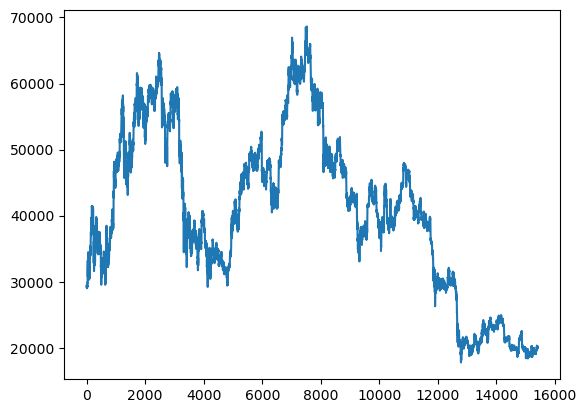

In [11]:
plt.plot(range(len(X)), X[['close']])

In [12]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.91135776, -0.89179937, -0.89979852, -0.88436979, -0.56489821,
        -0.57994107],
       [-0.87484656, -0.88806677, -0.88542285, -0.89708584, -0.56761491,
        -0.64182488],
       [-0.88501071, -0.89819242, -0.87589246, -0.8873196 , -0.607316  ,
        -0.7467583 ],
       ...,
       [-1.62021704, -1.62338729, -1.61750076, -1.61269223,  0.63621797,
         0.99675082],
       [-1.61152769, -1.61743103, -1.61485788, -1.62449144,  0.72547014,
         1.50527431],
       [-1.62348551, -1.63101131, -1.62478871, -1.63501507,  0.46870541,
         0.80033698]])

### Data Split for Training

In [13]:
# get array representation of dataframe
dataset = btc_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

12326

In [38]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])


# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


In [39]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(X_train.shape)
display(len(X_train))
display(len(X_test))


(12266, 60, 6)

12266

3080

In [40]:
# Create the target set selecting the Signal column and assiging it to y
y = btc_df['Signal']

# Review the value counts
display(y)

# Drop first row
# y = y.iloc[1:-candles]
y=y.iloc[candles+1:]

display(y)

timestamp
2021-01-01 01:00:00+00:00    1.0
2021-01-01 02:00:00+00:00    0.0
2021-01-01 03:00:00+00:00    1.0
2021-01-01 04:00:00+00:00    0.0
2021-01-01 05:00:00+00:00    1.0
                            ... 
2022-10-05 17:00:00+00:00    0.0
2022-10-05 18:00:00+00:00    1.0
2022-10-05 19:00:00+00:00    0.0
2022-10-05 20:00:00+00:00    0.0
2022-10-05 21:00:00+00:00    1.0
Name: Signal, Length: 15407, dtype: float64

timestamp
2021-01-03 16:00:00+00:00    0.0
2021-01-03 17:00:00+00:00    1.0
2021-01-03 18:00:00+00:00    0.0
2021-01-03 19:00:00+00:00    1.0
2021-01-03 20:00:00+00:00    1.0
                            ... 
2022-10-05 17:00:00+00:00    0.0
2022-10-05 18:00:00+00:00    1.0
2022-10-05 19:00:00+00:00    0.0
2022-10-05 20:00:00+00:00    0.0
2022-10-05 21:00:00+00:00    1.0
Name: Signal, Length: 15346, dtype: float64

In [41]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.count())
display(y_test.count())

12266

3080

## Model Creation

In [42]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [43]:
# Create the Sequential model instance
class_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = math.ceil(((number_input_features+1)*2)/3)
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

kernelSize=1

5

64

64

In [44]:
# # Add first cnn layer
# class_nn.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(candles,len(X.columns))))

In [45]:
# #Add second cnn layer
# class_nn.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))

In [46]:
# Add the first hidden layer
class_nn.add(LSTM(units=hidden_nodes_layer1, return_sequences=True,input_shape=(candles,len(X.columns))))

In [47]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [48]:
#Add the second hidden layer
class_nn.add(LSTM(units=hidden_nodes_layer2, return_sequences=True))


In [49]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [50]:
# # #Add the third hidden layer
# class_nn.add(LSTM(units=hidden_nodes_layer2))

In [51]:
# # Add dropout layer
# class_nn.add(Dropout(rate=0.2))

In [52]:
# Add Dense layer
# class_nn.add(Dense(units=6, activation='relu'))

In [53]:
# Add the output layer to the model specifying the number of output neurons and activation function
class_nn.add(Dense(units=1,  activation='sigmoid'))


In [54]:
# Display the Sequential model summary, subclassed model requires build
class_nn.build(X_train.shape)
class_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 64)            18176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             65        
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile the Sequential model
# class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [56]:
# Fit the model using epochs and the training data
class_model = class_nn.fit(X_train, y_train, epochs=60, validation_split=0.2)

Epoch 1/60
117/307 [==========>...................] - ETA: 5s - loss: 0.6955 - accuracy: 0.4914

KeyboardInterrupt: 

In [37]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = class_nn.evaluate(X_test, y_test)

model_loss, model_accuracy = class_nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

97/97 [==============================] - 1s 13ms/step - loss: 0.6948 - accuracy: 0.4955
Loss: 0.6948398947715759, Accuracy: 0.4954545497894287


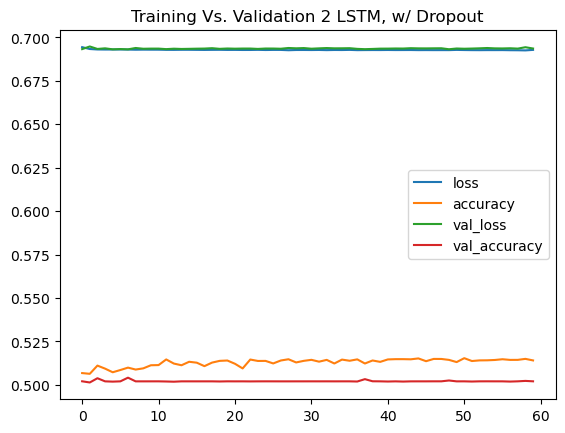

In [35]:
# Train vs test for loss
plt.plot(class_model.history["loss"])
plt.plot(class_model.history["accuracy"])
plt.plot(class_model.history["val_loss"])
plt.plot(class_model.history["val_accuracy"])
plt.title("Training Vs. Validation 2 LSTM, w/ Dropout")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()

In [36]:
# Set the file path for the first alternative model
file_path = Path('Models/class_class_nn.h5')

# Export your model to a HDF5 file
class_nn.save(file_path)